In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sqlite3

# Zad 1
Wczytaj dane ze wszystkich plików do pojedynczej tablicy (używając Pandas)

In [2]:
folder_path = './data/names'

file_list = glob.glob(os.path.join(folder_path, '*.txt'))

print(len(file_list))

names_df_list = []

for file in file_list:
    data = pd.read_csv(file, delimiter=',', header=None)
    year = int(os.path.basename(file).split('.')[0][-4:])
    data = pd.concat([data, pd.Series([year] * len(data))], axis=1)
    names_df_list.append(data)

143


In [3]:
names_df = pd.concat(names_df_list, ignore_index=True)

column_names = ['Name', 'Sex', 'Quanity', 'Year']

names_df.columns = column_names

print(names_df)

             Name Sex  Quanity  Year
0        Jennifer   F    56323  1978
1         Melissa   F    28328  1978
2         Jessica   F    26103  1978
3             Amy   F    23212  1978
4         Heather   F    22270  1978
...           ...  ..      ...   ...
2085153      Zeph   M        5  2000
2085154     Zeven   M        5  2000
2085155     Ziggy   M        5  2000
2085156        Zo   M        5  2000
2085157     Zyier   M        5  2000

[2085158 rows x 4 columns]


# Zad 2
Określi ile różnych (unikalnych) imion zostało nadanych w tym czasie

# Zad 3
Określi ile różnych (unikalnych) imion zostało nadanych w tym czasie rozróżniając imiona męskie i żeńskie

In [4]:
num_uniq_names = len(names_df['Name'].unique())
num_uniq_names_female = len(names_df.loc[names_df['Sex'] == 'F']['Name'].unique())
num_uniq_names_male = len(names_df.loc[names_df['Sex'] == 'M']['Name'].unique())

print("Number of unique names across data:", num_uniq_names)
print("Number of unique Female names across data:", num_uniq_names_female)
print("Number of unique Male names across data:", num_uniq_names_male)

Number of unique names across data: 102449
Number of unique Female names across data: 70227
Number of unique Male names across data: 43655


# Zad 4
Stwórz nowe kolumny frequency_male i frequency_female i określ popularność każdego z imion w danym każdym roku dzieląc liczbę razy, kiedy imię zostało nadane przez całkowita liczbę urodzeń dla danej płci

In [5]:
names_df_pivot = names_df.pivot_table(index=['Year', 'Sex', 'Name'], values='Quanity')

births_by_year = names_df_pivot.groupby(['Year', 'Sex']).sum()

# names_male_freq = names_df_pivot.loc[(slice(None), 'M'), :].apply(lambda x: x.values/x.sum())
# names_female_freq = names_df_pivot.loc[(slice(None), 'F'), :].apply(lambda x: x.values/x.sum())

names_male_freq = names_df_pivot.loc[(slice(None), 'M'), :] / births_by_year.loc[(slice(None), 'M'), :]
names_female_freq = names_df_pivot.loc[(slice(None), 'F'), :] / births_by_year.loc[(slice(None), 'F'), :]


names_df_pivot['frequency_male'] = names_male_freq
names_df_pivot['frequency_female'] = names_female_freq

names_df_pivot

Quanity  frequency_male  frequency_female
Year Sex Name                                              
1880 F   Abbie       71.0             NaN          0.000780
         Abby         6.0             NaN          0.000066
         Abigail     12.0             NaN          0.000132
         Ada        652.0             NaN          0.007165
         Adah        24.0             NaN          0.000264
...                   ...             ...               ...
2022 M   Zyren        8.0        0.000005               NaN
         Zyrie       11.0        0.000006               NaN
         Zyrin        6.0        0.000003               NaN
         Zyron       12.0        0.000007               NaN
         Zyrus        8.0        0.000005               NaN

[2085158 rows x 3 columns]

# Zad 5
Określ i wyświetl wykres złożony z dwóch podwykresów, gdzie osią x jest skala czasu, a oś y reprezentuje:
- liczbę urodzin w danym roku (wykres na górze)
- stosunek liczby narodzin dziewczynek do liczby narodzin chłopców w każdym roku(wykres na dole) W którym roku zanotowano najmniejszą, a w którym największą różnicę w liczbie urodzeń między chłopcami a dziewczynkami (pytanie dotyczy podwykresu przedstawiającego stosunek liczby urodzin)? Odpowiedź wyznacz i wyświetl na ekranie

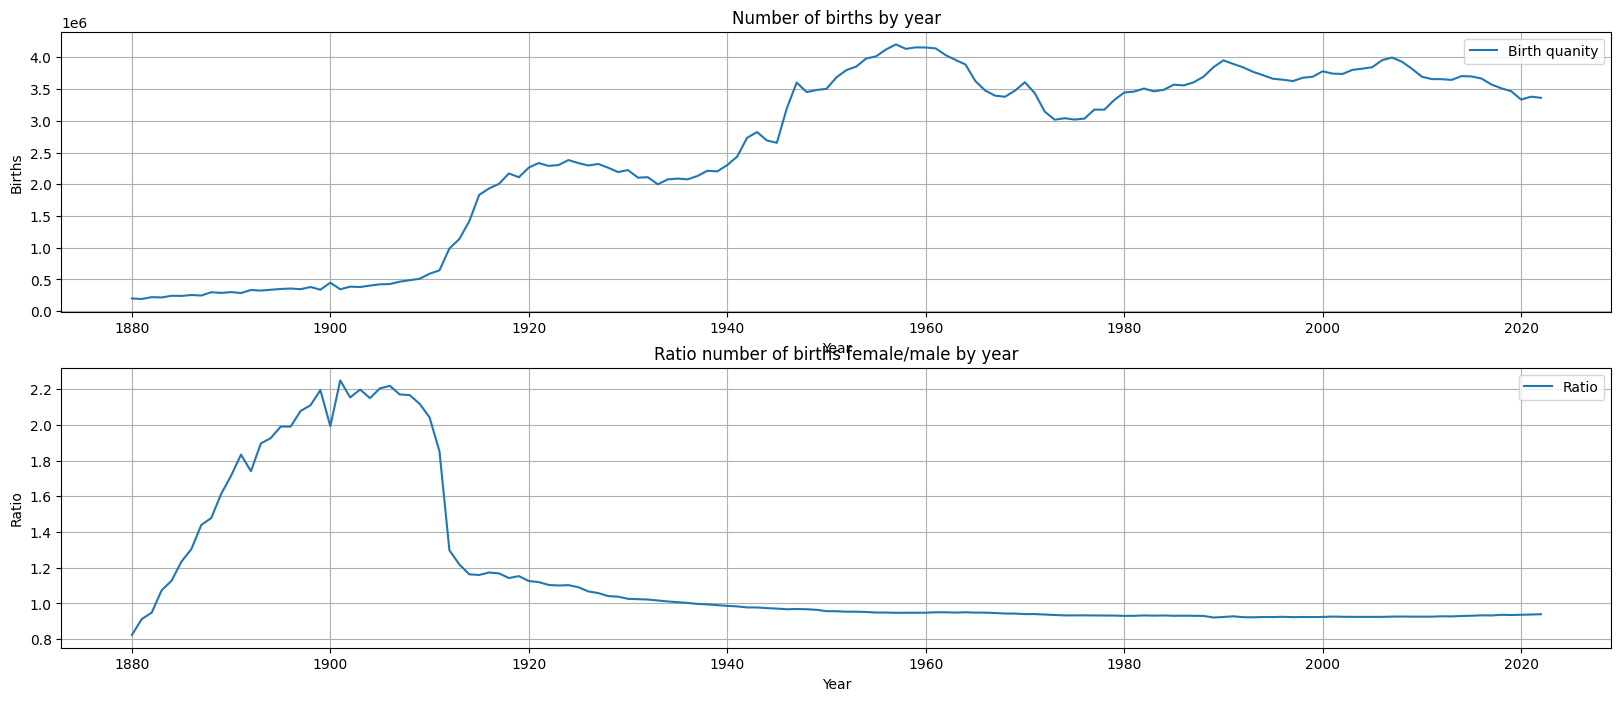

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))


years = names_df_pivot.index.get_level_values('Year').unique()
sum_by_year = names_df.groupby(['Year'])['Quanity'].sum()

ax[0].plot(years, sum_by_year.values, label='Birth quanity')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Births')
ax[0].set_title('Number of births by year')
ax[0].legend(loc='best')
ax[0].grid(True)

sum_by_year_female = names_df.groupby(['Year', 'Sex'])['Quanity'].sum().loc[(slice(None), 'F')]
sum_by_year_male = names_df.groupby(['Year', 'Sex'])['Quanity'].sum().loc[(slice(None), 'M')]
ratio = sum_by_year_female.values/sum_by_year_male.values

ax[1].plot(years, ratio, label='Ratio')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Ratio')
ax[1].set_title('Ratio number of births female/male by year')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.show()

# Zad 6
Wyznacz 1000 najpopularniejszych imion dla każdej płci w całym zakresie czasowym, metoda powinna polegać na wyznaczeniu 1000 najpopularniejszych imion dla każdego roku i dla każdej płci osobno. Jako najpopularniejsze należy uznać imiona, które najdłużej zajmowały wysokie miejsce na liście rankingowej, żeby uniknąć wpływu liczby urodzin w danym roku na wynik (liczba urodzin spada stąd, nieprawidłowo przeprowadzona procedura może powodować że imiona nadawane w wyżu i stosowane w tym czasie zdominują ranking) proszę ranking Top1000 określić jako sumę ważoną względnej popularności danego imienia w danym roku (patrz pkt 4)

In [7]:
top_names_df = names_df_pivot.copy().reset_index()

top_names_group_filtered = top_names_df.groupby(['Year', 'Sex']).apply(lambda x: x.nlargest(1000, 'frequency_male' if x['Sex'].iloc[0] == 'M' else 'frequency_female')).reset_index(drop=True)

top_names_group_filtered['weighted_sum_female'] = top_names_group_filtered['frequency_female'] * top_names_group_filtered['Quanity']
top_names_group_filtered['weighted_sum_male'] = top_names_group_filtered['frequency_male'] * top_names_group_filtered['Quanity']

top_names_pivot_female = top_names_group_filtered.pivot_table(index='Name', values='weighted_sum_female', aggfunc='sum')
top_names_pivot_male = top_names_group_filtered.pivot_table(index='Name', values='weighted_sum_male', aggfunc='sum')

name_counts_male = top_names_pivot_male.nlargest(1000, 'weighted_sum_male')
name_counts_female = top_names_pivot_female.nlargest(1000, 'weighted_sum_female')

# # print(top_names_female)
# name_counts_male = top_names_male['Name'].value_counts()
# name_counts_male

# name_counts_female = top_names_female['Name'].value_counts()
# top_names_female

name_counts_male.loc['Mary']

weighted_sum_male    3.074854
Name: Mary, dtype: float64

# Zad 7
Wyświetl na jednym wykresie zmiany dla imienia męskiego John i pierwszego imienia żeńskiego rankingu top-1000 (zaopatrz wykres w odpowiednią legendę):
- na osi Y po lewej liczbę razy kiedy imę zostało nadane w każdym roku (wyświetl ile razy nadano to imię w 1934, 1980 i 2022r)?
- na osi Y po prawej popularność tych imion w każdym z tych lat

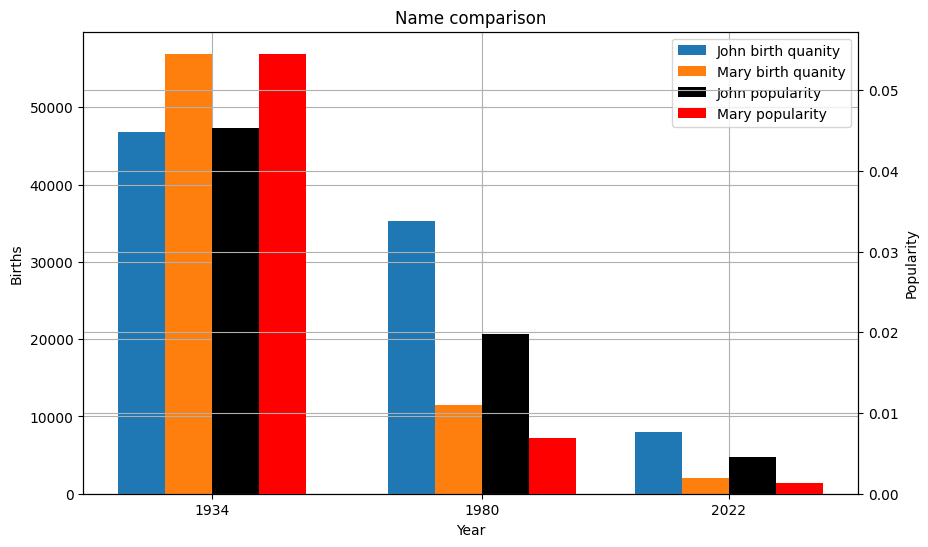

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

John_data = names_df_pivot.loc[([1934, 1980, 2022], 'M', 'John'), :]
top_female = name_counts_female.index[0]
top_female_data = names_df_pivot.loc[([1934, 1980, 2022], 'F', top_female), :]
years_3 = John_data.index.get_level_values('Year')

width = 8

bar1 = ax.bar(years_3-1.5*width, John_data['Quanity'], label='John birth quanity', width=width)
bar2 = ax.bar(years_3-width/2, top_female_data['Quanity'], label=f'{top_female} birth quanity', width=width)
ax.set_xlabel('Year')
ax.set_ylabel('Births')
ax.set_title('Name comparison')
ax.grid(True)
ax.set_xticks(years_3)
ax.set_xticklabels(years_3)

ax2 = ax.twinx()
bar3 = ax2.bar(years_3+width/2, John_data['frequency_male'], label='John popularity', color='black', width=width)
bar4 = ax2.bar(years_3+1.5*width, top_female_data['frequency_female'], label=f'{top_female} popularity', color='red', width=width)
ax2.set_ylabel('Popularity')
ax2.grid(True)

# Combine the legends
bars = [bar1, bar2, bar3, bar4]
labels = [bar.get_label() for bar in bars]
ax.legend(bars, labels, loc='best')

plt.show()


# Zad 8
Wykreśl wykres z podziałem na lata i płeć zawierający informację jaki procent w danym roku stanowiły imiona należące do rankingu top1000 (wyznaczonego dla całego zbioru (pkt 6)). Wykres ten opisuje różnorodność imion, wyświetl rok, w którym zaobserwowano największą różnicę w różnorodności między imionami męskimi a żeńskimi

dict_keys([1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])
{1880: {'female': 41.18895966029724, 'male': 45.93572778827977, 'difference': 4.746768127982527}, 1881: {'female': 42.004264392324

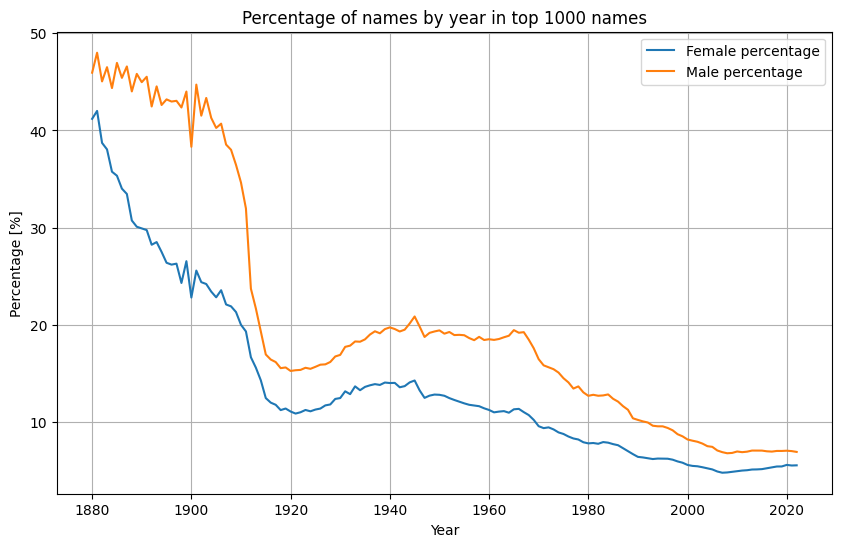

In [9]:
names_top_df_pivot = names_df.pivot_table(index=['Year', 'Sex'], values='Name', aggfunc=','.join)

same_names_percentage = {}

for year in years:
    names_year_female = set(names_top_df_pivot.loc[(year, 'F')].values[0].split(','))
    names_year_male = set(names_top_df_pivot.loc[(year, 'M')].values[0].split(','))

    female = (len(names_year_female.intersection(set(name_counts_female.index)))/len(names_year_female))*100
    male = (len(names_year_male.intersection(set(name_counts_male.index)))/len(names_year_male))*100
    
    same_names_percentage[year] = {
        'female': female,
        'male': male,
        'difference': abs(female - male)
    }

print(same_names_percentage.keys())
print(same_names_percentage)

fig, ax3 = plt.subplots(figsize=(10, 6))

years = list(same_names_percentage.keys())
female_percentages = [same_names_percentage[year]['female'] for year in years]
male_percentages = [same_names_percentage[year]['male'] for year in years]
max_diff, max_diff_year = max((same_names_percentage[year]['difference'], year) for year in years)

print(max_diff_year)

ax3.plot(years, female_percentages, label='Female percentage')
ax3.plot(years, male_percentages, label='Male percentage')
ax3.set_xlabel('Year')
ax3.set_ylabel('Percentage [%]')
ax3.set_title('Percentage of names by year in top 1000 names')
ax3.grid(True)
ax3.legend(loc='best')


# Zad 9
Zweryfikuj hipotezę czy prawdą jest, że w obserwowanym okresie rozkład ostatnich liter imion męskich uległ istotnej zmianie? W tym celu
- dokonaj agregacji wszystkich urodzeń w pełnym zbiorze danych z podziałem na rok i płeć i ostatnią literę,
- wyodrębnij dane dla lat 1917, 1967, 2022
- znormalizuj dane względem całkowitej liczby urodzin w danym roku
- wyświetl dane popularności litery dla mężczyzn w postaci wykresu słupkowego zawierającego poszczególne lata i gdzie słupki grupowane są wg litery. Wyświetl, dla której litery wystąpił największy wzrost/spadek między rokiem 1917 a 2022)
- Dla 3 liter dla których zaobserwowano największą zmianę wyświetl przebieg trendu popularności w maksymalnym przedziale czasu

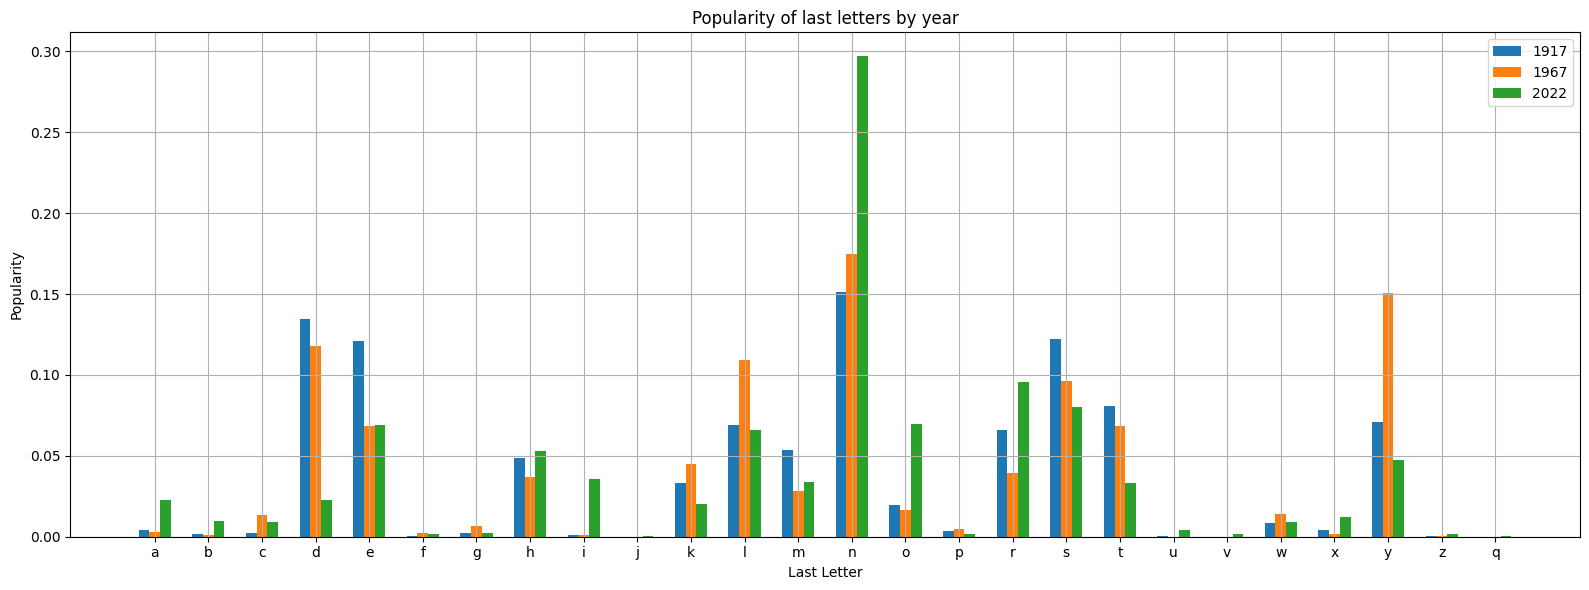

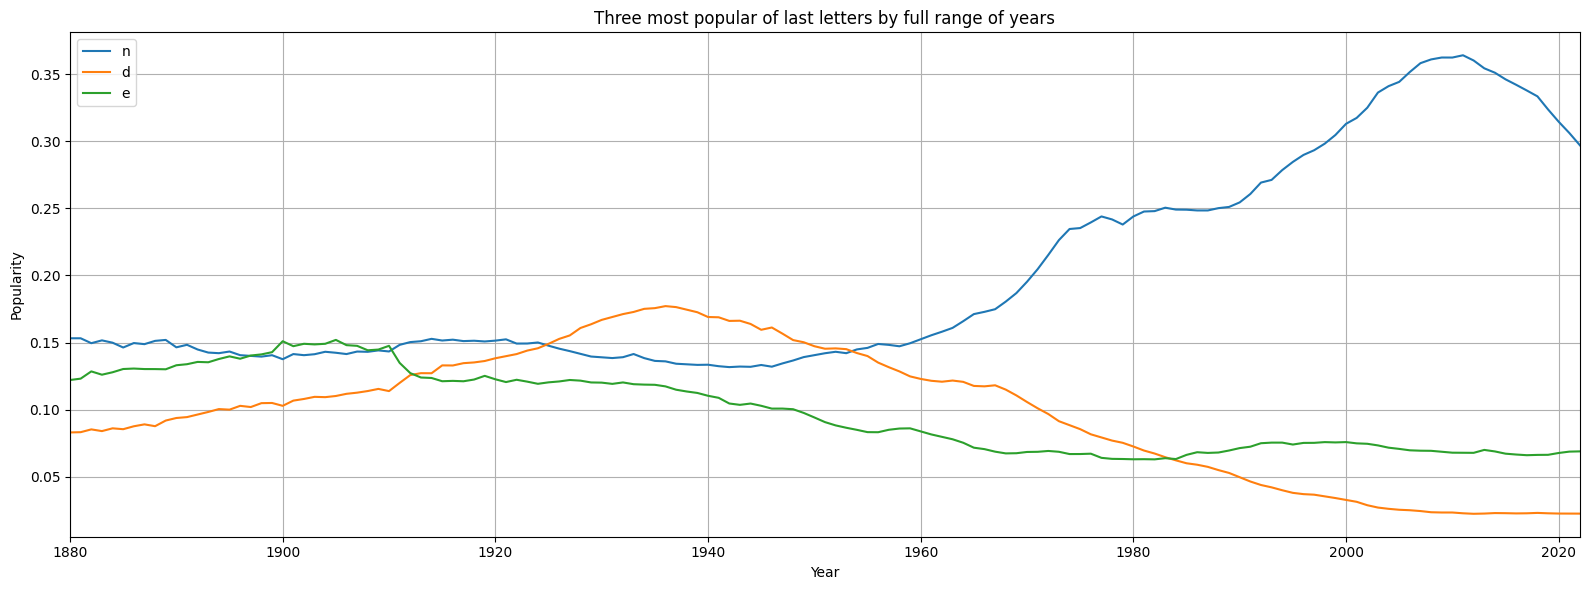

In [10]:
last_letter_df_pivot = names_df.copy()
last_letter_df_pivot['Last letter'] = last_letter_df_pivot['Name'].str[-1]
last_letter_df_pivot = last_letter_df_pivot.pivot_table(index=['Year', 'Sex', 'Last letter'], values='Quanity', aggfunc='sum')

sum_by_year_sex = last_letter_df_pivot.groupby(['Year', 'Sex']).sum()
last_letter_df_pivot['Quanity normalization'] = last_letter_df_pivot['Quanity'] / sum_by_year_sex['Quanity']

extract = last_letter_df_pivot.loc[([1917, 1967, 2022], 'M'), :]

years_extract = extract.index.get_level_values('Year').unique()

extract = extract.reindex(pd.MultiIndex.from_product([years_extract, ['M'], extract.index.get_level_values('Last letter').unique()], names=['Year', 'Sex', 'Last letter']), fill_value=0)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(last_letter_df_pivot)


width = 0.2

data = extract.groupby(['Year'])['Quanity normalization']

fig, ax4 = plt.subplots(figsize=(16, 6))

for i, year in enumerate(years_extract):
    year_data = data.get_group(year)
    letters = year_data.index.get_level_values('Last letter')
    quantities = year_data.values

    x = np.arange(0, len(letters))
    ax4.bar(x + (i - len(letters) / 2) * width - width, quantities, width=width, label=str(year))

ax4.set_xlabel('Last Letter')
ax4.set_ylabel('Popularity')
ax4.set_title(f'Popularity of last letters by year')
ax4.grid(True)

ax4.set_xticks(x - (len(letters) / 2) * width)
ax4.set_xticklabels(letters)

ax4.legend(loc='best')

plt.tight_layout()
plt.show()

difference = abs(extract.loc[(1917, 'M'), :]['Quanity normalization'] - extract.loc[(2022, 'M'), :]['Quanity normalization'])

max_difference_letter = difference.nlargest(1)
max_difference_letter

top_3_max_values = difference.nlargest(3)
top_3_letters = list(top_3_max_values.index.get_level_values('Last letter'))

first_letter = last_letter_df_pivot.loc[(slice(None), 'M', top_3_letters[0]), :]['Quanity normalization']
second_letter = last_letter_df_pivot.loc[(slice(None), 'M', top_3_letters[1]), :]['Quanity normalization']
third_letter = last_letter_df_pivot.loc[(slice(None), 'M', top_3_letters[2]), :]['Quanity normalization']

fig, ax4 = plt.subplots(figsize=(16, 6))


ax4.plot(years, first_letter.values, label=top_3_letters[0])
ax4.plot(years, second_letter.values, label=top_3_letters[1])
ax4.plot(years, third_letter.values, label=top_3_letters[2])

ax4.set_xlabel('Year')
ax4.set_ylabel('Popularity')
ax4.set_title(f'Three most popular of last letters by full range of years')
ax4.grid(True)

# ax4.set_xticks(years)
# ax4.set_xticklabels(years)

ax4.legend(loc='best')
plt.xlim(years[0], years[-1])

plt.tight_layout()
plt.show()

# Zad 10
Znajdź w rankingu top1000 imiona, które nadawane były zarówno dziewczynkom jak i chłopcom (stosunek nadanych imion męskich i żeńskich). Wyznacz 2 imiona, dla których zaobserwowano największą zmianę (definiowanej jako największa różnica stosunku imion męskich do żeńskich w badanych latach). Do analizy zmiany wykorzystaj 2 przedziały: zagregowane dane do roku 1930 i od roku 2000.
- wyświetl te imiona
- wkreśl przebieg trendu dla tych imion

In [11]:
def aggregated_trend(years, selected_years, selected_years_female_names, selected_years_male_names):
    common_names_table = []

    for year in selected_years['Year'].unique():
        female_data = selected_years_female_names.loc[year]
        male_data = selected_years_male_names.loc[year]
        common_names = female_data.index[female_data.index.isin(male_data.index)].values
        year_data = pd.DataFrame({'Year': [year] * len(common_names), 'Name': common_names})
        year_data = pd.concat([year_data], axis=1)
        # print(year_data)
        common_names_table.append(year_data)

    common_names_table = pd.concat(common_names_table, ignore_index=True)


    filtered_names = [common_names_table[common_names_table['Year'] == year]['Name'].values for year in years]

    filtered_names_df_female = names_df_pivot.loc[(years, 'F'), :]
    filtered_names_df_male = names_df_pivot.loc[(years, 'M'), :]

    column_names_male = ['Quanity male']
    column_names_female = ['Quanity female']

    common_female = pd.concat([filtered_names_df_female.loc[(year, 'F', list(filtered_names[i])), :] for i, year in enumerate(years)]).drop(columns=['frequency_female', 'frequency_male'])
    common_male = pd.concat([filtered_names_df_male.loc[(year, 'M', list(filtered_names[i])), :] for i, year in enumerate(years)]).drop(columns=['frequency_female', 'frequency_male'])

    common_female.columns = column_names_female
    common_male.columns = column_names_male

    common_female = common_female.reset_index()
    common_male = common_male.reset_index()

    merged_pivot = common_female.combine_first(common_male)

    plot_merged_pivot = merged_pivot.copy()

    merged_pivot = merged_pivot.pivot_table(index=['Name'], values=['Quanity female', 'Quanity male'], aggfunc='sum')

    merged_pivot['frequency_male'] = merged_pivot['Quanity male'] / (merged_pivot['Quanity male'].sum() + merged_pivot['Quanity female'].sum())
    merged_pivot['frequency_female'] = merged_pivot['Quanity female'] / (merged_pivot['Quanity male'].sum() + merged_pivot['Quanity female'].sum())

    merged_pivot['Ratio'] = abs(merged_pivot['frequency_male'] - merged_pivot['frequency_female'])

    max_2_diff = merged_pivot['Ratio'].nlargest(2)

    # print(max_2_diff)

    name = max_2_diff.index

    print(f'Names with biggest difference between {years[0]} and {years[-1]}')
    print(name)


    fig, ax5 = plt.subplots(figsize=(16, 6))

    diff = [plot_merged_pivot[plot_merged_pivot['Name'] == name[0]]['Quanity female'] + plot_merged_pivot[plot_merged_pivot['Name'] == name[0]]['Quanity male'],
            plot_merged_pivot[plot_merged_pivot['Name'] == name[1]]['Quanity female'] + plot_merged_pivot[plot_merged_pivot['Name'] == name[1]]['Quanity male']]



    ax5.plot(years, diff[0], label=name[0])
    ax5.plot(years, diff[1], label=name[1])
    ax5.set_xlabel('Year')
    ax5.set_ylabel('Popularity')
    ax5.set_title(f'Name with biggest difference between male and female ratio aggregated {years[0]} - {years[-1]}')
    ax5.grid(True)

    # ax4.set_xticks(years)
    # ax4.set_xticklabels(years)

    ax5.legend(loc='best')


    plt.tight_layout()
    plt.show()

Names with biggest difference between 1880 and 1930
Index(['Mary', 'John'], dtype='object', name='Name')


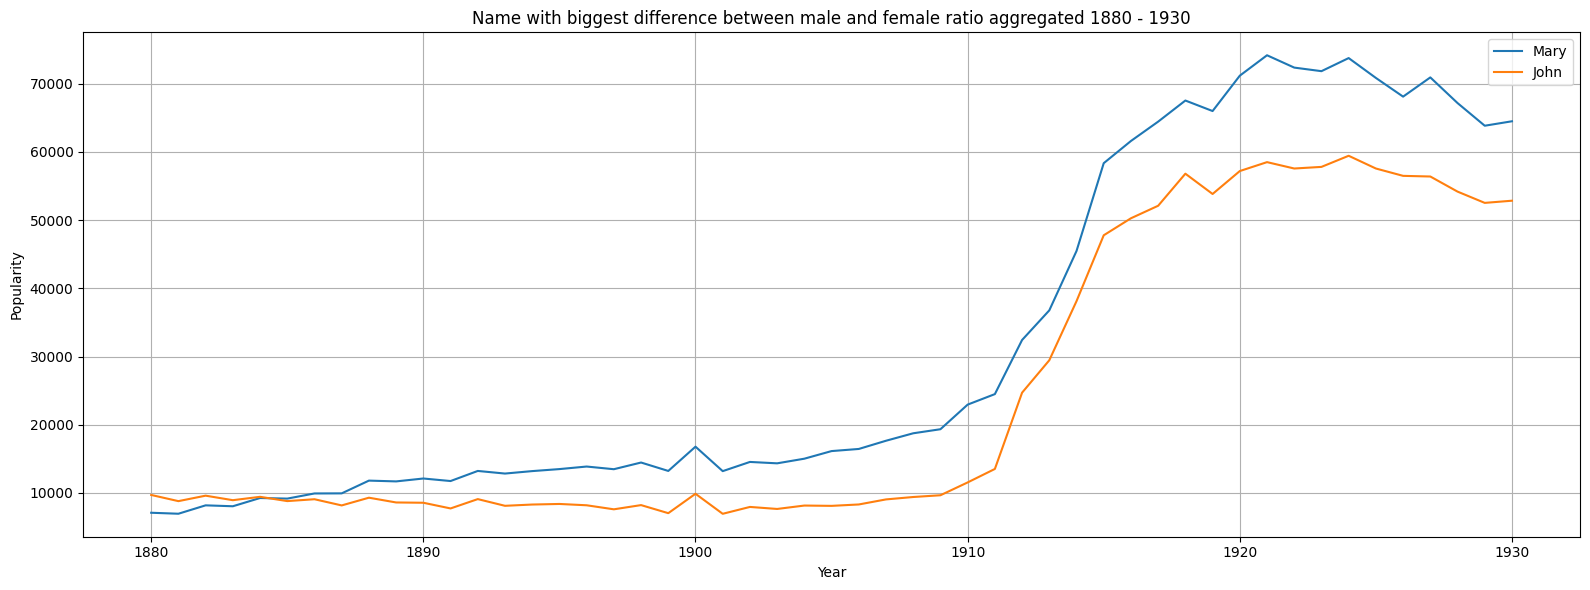

In [12]:
name_counts_male
name_counts_female
top_names_group_filtered

before_1930 = top_names_group_filtered[top_names_group_filtered['Year'] <= 1930]
since_2000 = top_names_group_filtered[top_names_group_filtered['Year'] >= 2000]

before_1930_female_names = before_1930[before_1930['Sex'] == 'F']
before_1930_male_names = before_1930[before_1930['Sex'] == 'M']
since_2000_female_names = since_2000[since_2000['Sex'] == 'F']
since_2000_male_names = since_2000[since_2000['Sex'] == 'M']

before_1930_female_names = before_1930_female_names.pivot_table(index=['Year', 'Name'], values='Quanity')
before_1930_male_names = before_1930_male_names.pivot_table(index=['Year', 'Name'], values='Quanity')
since_2000_female_names = since_2000_female_names.pivot_table(index=['Year', 'Name'], values='Quanity')
since_2000_male_names = since_2000_male_names.pivot_table(index=['Year', 'Name'], values='Quanity')

years_1930 = list(before_1930_female_names.index.get_level_values('Year').unique().values)
years_2000 = list(since_2000_female_names.index.get_level_values('Year').unique().values)

# yearly_data = pd.DataFrame(columns=['Year', 'Name'])

aggregated_trend(years_1930, before_1930, before_1930_female_names, before_1930_male_names)
aggregated_trend(years_2000, since_2000, since_2000_female_names, since_2000_male_names)




# Zad 1
Wczytaj dane z bazy opisującej dane demograficzne w okresie od 1935-2020r w poszczególnych grupach wiekowych W USA: USA_demography, opis: https://www.mortality.org/Data/ExplanatoryNotes ([wersja_pdf](_resources/lab_04/Explanatory Notes.pdf)). Spróbuj zagregować dane już na etapie zapytania SQL.

In [ ]:
conn = sqlite3.connect("./data/demography_us_2023.sqlite3")
c = conn.cursor()

df_births = pd.read_sql_query("SELECT * FROM births", conn)
df_deaths = pd.read_sql_query("SELECT * FROM deaths", conn)
df_population = pd.read_sql_query("SELECT * FROM population", conn)

conn.close()

# Zad 2
Wyznacz i wyświetl przyrost naturalny w każdym roku analizowanego okresu

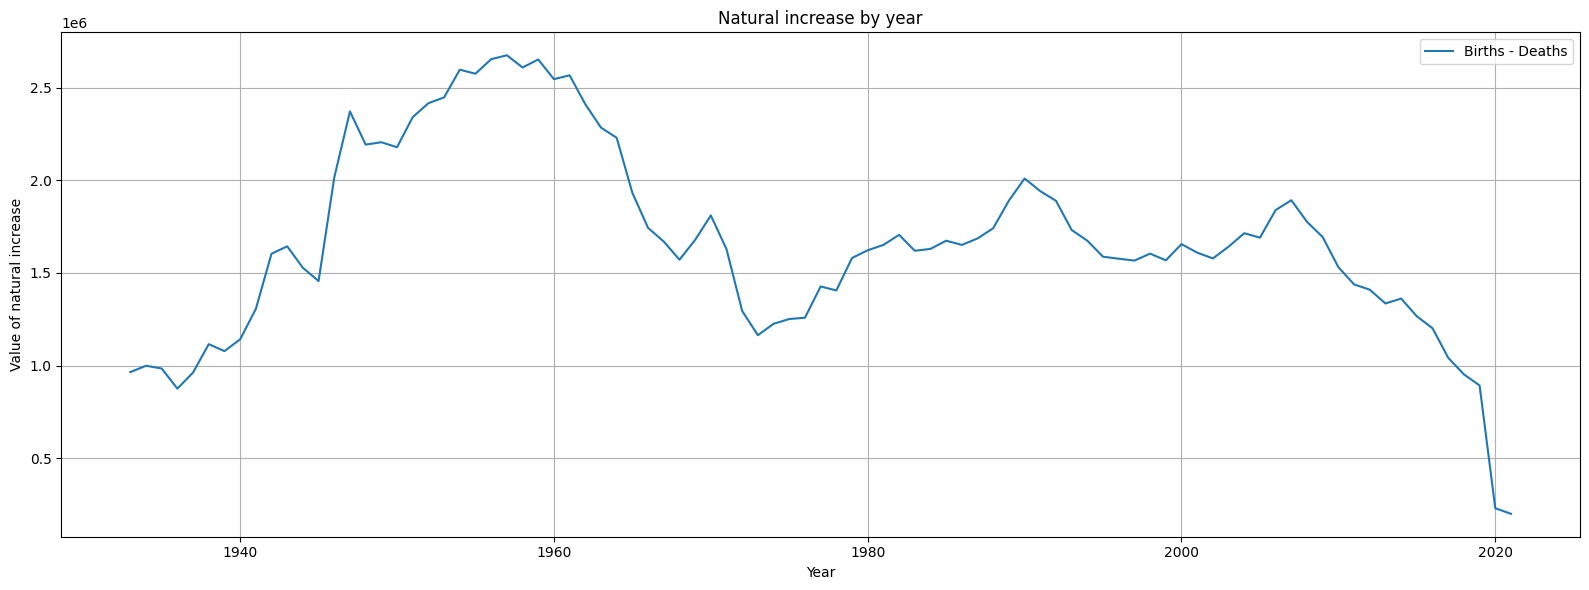

In [ ]:
df_deaths_by_year = df_deaths.pivot_table(index=['Year'], values='Total', aggfunc='sum')
df_births_by_year = df_births.pivot_table(index=['Year'], values='Total', aggfunc='sum')

natural_increase = df_births_by_year - df_deaths_by_year

fig, ax6 = plt.subplots(figsize=(16, 6))


ax6.plot(df_deaths_by_year.index, natural_increase.values, label='Births - Deaths')
ax6.set_xlabel('Year')
ax6.set_ylabel('Value of natural increase')
ax6.set_title(f'Natural increase by year')
ax6.grid(True)

ax4.set_xticks(df_deaths_by_year.index)
ax4.set_xticklabels(df_deaths_by_year.index)

ax6.legend(loc='best')


plt.tight_layout()
plt.show()

# Zad 3
Wyznacz i wyświetl współczynnik przeżywalności dzieci w pierwszym roku życia ww każdym roku analizowanego okresu.